In [12]:
import os, sys
import h5py
import numpy as np
from scipy.io import loadmat
import cv2
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import matrix as mat
from sympy import *
from numpy import linalg as la

In [13]:
def getFx(para, frame):   # para中为(11*frame+3)的一套参数，frame传进来是为了确定循环次数
    #先写出参数表达式，ABDCDEF六个点的齐次坐标
    K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                     [0.0, 1147.59161666764, 508.064917088557],
                     [0.0, 0.0, 1.0]])
    r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33 = symbols('r11 r12 r13 r14 r21 r22 r23 r24 r31 r32 r33')
    Rt = Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, 1]])
    a, b, c = symbols('a b c')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    f = Symbol('f')
    XA = Matrix([[-a * c], [c], [0], [1]])
    XB = Matrix([[0], [c], [0], [1]])
    XC = Matrix([[a * c], [c], [0], [1]])
    XD = Matrix([[-b * c], [0], [0], [1]])
    XE = Matrix([[0], [0], [0], [1]])
    XF = Matrix([[b * c], [0], [0], [1]])
    ua, va, wa = K[0,:] * (Rt * XA), K[1,:] * (Rt * XA), K[2,:] * (Rt * XA)
    ub, vb, wb = K[0,:] * (Rt * XB), K[1,:] * (Rt * XB), K[2,:] * (Rt * XB)
    uc, vc, wc = K[0,:] * (Rt * XC), K[1,:] * (Rt * XC), K[2,:] * (Rt * XC)
    ud, vd, wd = K[0,:] * (Rt * XD), K[1,:] * (Rt * XD), K[2,:] * (Rt * XD)
    ue, ve, we = K[0,:] * (Rt * XE), K[1,:] * (Rt * XE), K[2,:] * (Rt * XE)
    uf, vf, wf = K[0,:] * (Rt * XF), K[1,:] * (Rt * XF), K[2,:] * (Rt * XF)
    #根据每一帧的循环，提取出Rt的参数，K是公用的，代入参数写出3D坐标，并计算出u/w，v/w
    #写成f的形式，即按照六个点分块，每块里面有M帧
    getfx = mat(np.zeros((6*frame*2,1)))
    for i in range(6):
        for j in range(frame):
            if i == 0 :
                f = Matrix([ua/wa, va/wa])
            elif i == 1 :
                f = Matrix([ub/wb, vb/wb])
            elif i == 2 :
                f = Matrix([uc/wc, vc/wc])
            elif i == 3 :
                f = Matrix([ud/wd, vd/wd])
            elif i == 4 :
                f = Matrix([ue/we, ve/we])
            else:
                f = Matrix([uf/wf, vf/wf])
            f_value = f.subs({r11:para[11*j], r12:para[11*j+1], r13:para[11*j+2], r14:para[11*j+3], 
                        r21:para[11*j+4], r22:para[11*j+5], r23:para[11*j+6], r24:para[11*j+7], 
                        r31:para[11*j+8], r32:para[11*j+9], r33:para[11*j+10], a:para[-3], b:para[-2], c:para[-1]})
            getfx[i*frame*2+j*2] = f_value[0]
            getfx[i*frame*2+j*2+1] = f_value[1]
    #返回getfx值，2*frame*6 by 1
    return getfx

In [22]:
def getJacobian(point, frame, para):
    # 用参数表示K，R矩阵
    focalx, focaly, px, py = symbols('focalx focaly px py')
    r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33 = symbols('r11 r12 r13 r14 r21 r22 r23 r24 r31 r32 r33')
    Rt = Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, 1]])
    K = Matrix([[focalx, 0, px], [0, focaly, py], [0, 0, 1]])
    # KRt = K * Rt
    # 用参数表示ABCDEF六个点坐标
    a, b, c = symbols('a b c')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    f = Symbol('f')
    if point == 0 :
        XA = Matrix([[-a * c], [c], [0], [1]])
        ua, va, wa = K[0,:] * (Rt * XA), K[1,:] * (Rt * XA), K[2,:] * (Rt * XA)
        f = Matrix([ua/wa, va/wa])
    elif point == 1 :
        XB = Matrix([[0], [c], [0], [1]])
        ub, vb, wb = K[0,:] * (Rt * XB), K[1,:] * (Rt * XB), K[2,:] * (Rt * XB)
        f = Matrix([ub/wb, vb/wb])
    elif point == 2 :
        XC = Matrix([[a * c], [c], [0], [1]])
        uc, vc, wc = K[0,:] * (Rt * XC), K[1,:] * (Rt * XC), K[2,:] * (Rt * XC)
        f = Matrix([uc/wc, vc/wc])
    elif point == 3 :
        XD = Matrix([[-b * c], [0], [0], [1]])
        ud, vd, wd = K[0,:] * (Rt * XD), K[1,:] * (Rt * XD), K[2,:] * (Rt * XD)
        f = Matrix([ud/wd, vd/wd])
    elif point == 4 :
        XE = Matrix([[0], [0], [0], [1]])
        ue, ve, we = K[0,:] * (Rt * XE), K[1,:] * (Rt * XE), K[2,:] * (Rt * XE)
        f = Matrix([ue/we, ve/we])
    elif point == 5:
        XF = Matrix([[b * c], [0], [0], [1]])
        uf, vf, wf = K[0,:] * (Rt * XF), K[1,:] * (Rt * XF), K[2,:] * (Rt * XF)
        f = Matrix([uf/wf, vf/wf])
    args = Matrix([r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33, a, b, c])
    f_X1 = f[0,:].jacobian(args)
    f_X2 = f[1,:].jacobian(args)
    JA = Matrix([f_X1, f_X2])   # 2 by 16 matrix
    JA_value = JA.subs({focalx:1149.676, focaly:1147.592, px:508.849, py:508.065, r11:para[11*frame], r12:para[11*frame+1], 
                                 r13:para[11*frame+2], r14:para[11*frame+3], r21:para[11*frame+4], r22:para[11*frame+5], 
                                 r23:para[11*frame+6], r24:para[11*frame+7], r31:para[11*frame+8], r32:para[11*frame+9], 
                                 r33:para[11*frame+10], a:para[-3], b:para[-2], c:para[-1]})
    #JA_value = JA_value.subs({f:1149.68})
    return JA_value

In [24]:
def getJ(para, frame):
    getj = mat(np.zeros((6*frame*2, 11*frame+3)))
    for m in range(6):
        for n in range(frame):
            JA_value = getJacobian(m, n, para)
            #print(JA_value)
            getj[2*(m*frame+n):2*(m*frame+n+1), 11*n:11*n+11] = JA_value[:, 0:11]
            getj[2*(m*frame+n):2*(m*frame+n+1), -3:] = JA_value[:, -3:]
    return getj

In [16]:
def getE(getfx, frame, k, xkp):
    E = mat(np.zeros((6*frame*2,1)))
    for i in range(6):
        for j in range(frame):
            if i==0 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==1 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==2 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==3 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==4 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
            elif i==5 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - xkp[i*3+k,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - xkp[i*3+k, 1]
    return E

In [17]:
def LM_opti(frame, ith, x2d, x_para, u=1, v=2, step_max=500):
    J = mat(np.zeros((6*frame*2, 11*frame+3)))
    E = mat(np.zeros((6*frame*2,1)))   # E = f(X) - b ;
    E_temp = mat(np.zeros((6*frame*2,1)))   # E_temp compare with E in L-M
    x_k = mat(x_para.copy())   #parameter initialization
    step = 0   # iteration steps
    mse_last = 0   # mse value after iteration each time
    
    # L-M Algorithm obtain optimal parameters
    while(step < step_max):
        step += 1
        mse, mse_temp = 0, 0

        # generate Jacobian Matrix and calculate E
        getfx = mat(np.zeros((6*frame*2,1)))
        getfx = getFx(x_k, frame)
        E = getE(getfx, frame, ith, x2d)   #单帧模式，第几帧，GT

        for i in range(6*frame*2):
            mse += E[i]**2
        mse /= 6*frame*2

        # get new J
        J = mat(np.zeros((6*frame*2, 11*frame+3)))
        J = getJ(x_k, frame)

        # delta X = ...
        #print(J.T * J)
        dx = mat(np.zeros((11*frame+3,1)))
        LM = u * mat(np.eye(11*frame+3))
        dx = -(J.T * J + LM).I * J.T * E
        x_k_temp = x_k.copy()
        x_k_temp += dx
        
        #R的更新不能简单赋值
        #get R meet R.T*R=I
        #U * D * V.T = R --> R+ = U * V.T
        '''
        R_old = mat([[x_k_temp[0,0], x_k_temp[1,0], x_k_temp[2,0]], 
                     [x_k_temp[4,0], x_k_temp[5,0], x_k_temp[6,0]], 
                     [x_k_temp[8,0], x_k_temp[9,0], x_k_temp[10,0]]])
        U, sigma, VT = la.svd(R_old)
        R_new = U * VT
        x_k_temp[0,0], x_k_temp[1,0], x_k_temp[2,0] = R_new[0,0], R_new[0,1], R_new[0,2]
        x_k_temp[4,0], x_k_temp[5,0], x_k_temp[6,0] = R_new[1,0], R_new[1,1], R_new[1,2]
        x_k_temp[8,0], x_k_temp[9,0], x_k_temp[10,0] = R_new[2,0], R_new[2,1], R_new[2,2]
        '''
        ###########

        # calculate E_temp with x_k_temp
        # copy from E with x_k
        getfx_temp = mat(np.zeros((6*frame*2,1)))
        getfx_temp = getFx(x_k_temp, frame)
        E_temp = getE(getfx_temp, frame, ith, x2d)

        for i in range(6*frame*2):
            mse_temp += E_temp[i]**2
        mse_temp /= 6*frame*2

        # segma value to choose optimization model
        segma = (mse - mse_temp)/((dx.T * (u * dx - J.T * E))[0,0])

        # calculate new u
        if segma > 0:
            s = 1.0/3.0
            v = 2
            x_k = x_k_temp
            mse = mse_temp
            u = u * max(s, 1-pow(2*segma,3))
            u = u[0,0]
        else:
            u = u * v
            v = v * 2
            x_k = x_k_temp
            
        print("step = %d, abs(mse-mse_last) = %.8f" %(step, abs(mse-mse_last)))
        if abs(mse-mse_last)<0.000001:
            break    
        mse_last = mse

    print("step = ", step)
    print("mse = ", mse_last)
    #print("parameter = ", x_k)
    
    return x_k

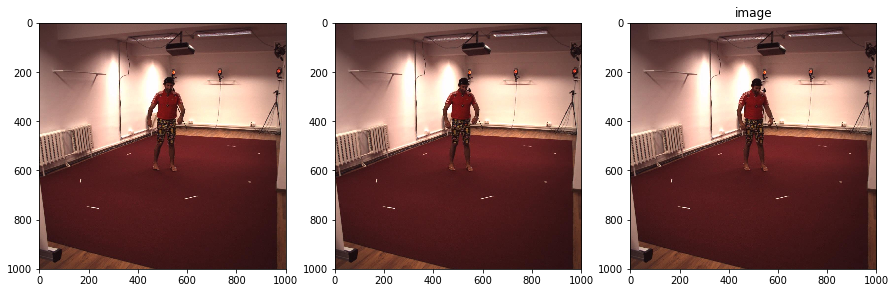

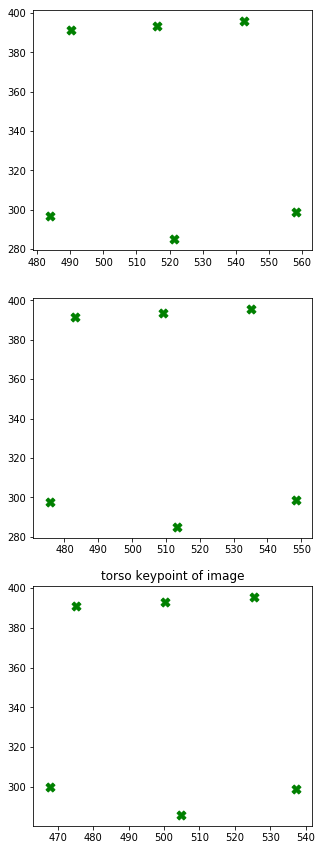

[[483.83330182 297.02895882]
 [475.6360488  297.90329019]
 [467.76985713 300.05987121]
 [521.42362196 285.01172463]
 [513.13288499 285.01206725]
 [504.68560881 285.88833555]
 [558.27002512 298.71850852]
 [548.54133329 298.82089764]
 [537.32923715 299.08072969]
 [490.11721691 391.47081586]
 [483.05709289 391.56314353]
 [475.17514487 390.94737465]
 [516.29540914 393.64693794]
 [509.17089976 393.55318747]
 [500.40525171 393.26600811]
 [542.46158091 395.86354434]
 [535.15509005 395.57472527]
 [525.29982451 395.59529855]]


In [18]:
frame = 3
m = loadmat("valid.mat")

# camera intrinsic matrix
K = m["annot"][0][0][4]
K_cam = K[0][0].tolist()

# key point 3D groundtruth
gt = m["annot"][0][0][3]
img_gt = np.zeros((frame, 3, 17))
img1_gt = gt[135]   # array 3 by 17
img2_gt = gt[136]   # array 3 by 17
img3_gt = gt[137]   # array 3 by 17
img_gt[0] = img1_gt
img_gt[1] = img2_gt
img_gt[2] = img3_gt
#print(img_gt)

# key point 2D groundtruth
kp = np.zeros((frame, 17, 2))
for m in range(frame):
    for i in range(17):
        u = K_cam[0] * mat([img_gt[m][0][i], img_gt[m][1][i], img_gt[m][2][i]]).T
        v = K_cam[1] * mat([img_gt[m][0][i], img_gt[m][1][i], img_gt[m][2][i]]).T
        w = K_cam[2] * mat([img_gt[m][0][i], img_gt[m][1][i], img_gt[m][2][i]]).T
        kp[m][i][0] = u/w
        kp[m][i][1] = v/w
#print(kp)

# show image
img1 = cv2.imread("S9_Posing_1.55011271_000676.jpg")
img2 = cv2.imread("S9_Posing_1.55011271_000681.jpg")
img3 = cv2.imread("S9_Posing_1.55011271_000686.jpg")
plt.figure(figsize = (15, 45)) # 图像窗口名称
plt.subplot(131)
plt.imshow(img1[:,:,[2,1,0]])
plt.subplot(132)
plt.imshow(img2[:,:,[2,1,0]])
plt.subplot(133)
plt.imshow(img3[:,:,[2,1,0]])
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

# visualize key points
"""
txt = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.figure()
plt.subplot(131)
img_kp = plt.scatter(kp[0][:,0], kp[0][:,1], s = 80, c = 'g', marker = 'X')
for i in range(17):
    plt.annotate(txt[i], xy = (kp[0][i,0], kp[0][i,1]), xytext = (kp[0][i,0]+0.1, kp[0][i,1]+0.1))
plt.subplot(132)
img_kp = plt.scatter(kp[1][:,0], kp[1][:,1], s = 80, c = 'g', marker = 'X')
for i in range(17):
    plt.annotate(txt[i], xy = (kp[1][i,0], kp[1][i,1]), xytext = (kp[1][i,0]+0.1, kp[1][i,1]+0.1))
plt.subplot(133)
img_kp = plt.scatter(kp[2][:,0], kp[2][:,1], s = 80, c = 'g', marker = 'X')
for i in range(17):
    plt.annotate(txt[i], xy = (kp[2][i,0], kp[2][i,1]), xytext = (kp[2][i,0]+0.1, kp[2][i,1]+0.1)) # 这里xy是需要标记的坐标，xytext是对应的标签坐标
plt.axis('on') # 关掉坐标轴为 off
plt.title('keypoint of image') # 图像题目
"""

# visualize torso joints A-F
plt.figure(figsize = (5,15))
plt.subplot(311)
for i in {0,1,4,8,11,14}:
    img_kp = plt.scatter(kp[0][i,0], kp[0][i,1], s = 80, c = 'g', marker = 'X')
plt.subplot(312)
for i in {0,1,4,8,11,14}:
    img_kp = plt.scatter(kp[1][i,0], kp[1][i,1], s = 80, c = 'g', marker = 'X')
plt.subplot(313)
for i in {0,1,4,8,11,14}:
    img_kp = plt.scatter(kp[2][i,0], kp[2][i,1], s = 80, c = 'g', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('torso keypoint of image') # 图像题目
plt.show()

# save 2D keypoint coordinate
x2d = np.zeros((6 * frame,2))   #[AAABBBCCCDDDEEEFFF].T
for i in range(6):
    for j in range(frame):
        if i==0 :
            x2d[i*frame+j, :] = kp[j][14, :]
        elif i==1 :
            x2d[i*frame+j, :] = kp[j][8, :]
        elif i==2 :
            x2d[i*frame+j, :] = kp[j][11, :]
        elif i==3 :
            x2d[i*frame+j, :] = kp[j][4, :]
        elif i==4 :
            x2d[i*frame+j, :] = kp[j][0, :]
        elif i==5 :
            x2d[i*frame+j, :] = kp[j][1, :]
print(x2d)

In [19]:
# parameter initialization for first frame
x_para = np.zeros((11+3,1))
x_para[0] = -1   # r11
x_para[5] = 1   # r22
x_para[10] = -1   # r33
x_para[3] = 0.0047   #tx(cal)
x_para[7] = -0.0997   #ty(cal)
#x_para[11] = 0   # th
#x_para[12] = 0   #al
x_para[-3] = 0.35   # a
x_para[-2] = 0.25   # b
x_para[-1] = -0.095  # c(cal)
getfx_ini = getFx(x_para, 1)
print(getfx_ini)

[[476.02538041]
 [284.62882932]
 [514.25209744]
 [284.62882932]
 [552.47881446]
 [284.62882932]
 [486.94729956]
 [393.65003291]
 [514.25209744]
 [393.65003291]
 [541.55689531]
 [393.65003291]]


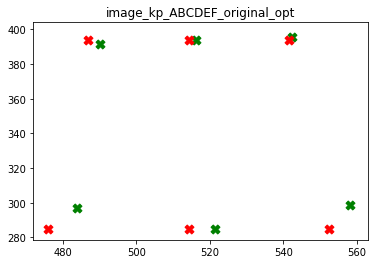

In [20]:
# visualize first frame after initilization
plt.figure()
img_kp = plt.scatter(kp[0][14,0], kp[0][14,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[0,0], getfx_ini[1,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][8,0], kp[0][8,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[2,0], getfx_ini[3,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][11,0], kp[0][11,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[4,0], getfx_ini[5,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][4,0], kp[0][4,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[6,0], getfx_ini[7,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][0,0], kp[0][0,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[8,0], getfx_ini[9,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0][1,0], kp[0][1,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[10,0], getfx_ini[11,0], s = 80, c = 'r', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('image_kp_ABCDEF_original_opt') # 图像题目
plt.show()

In [25]:
# optimization for each frame
X_para = np.zeros((11*frame+3,1))
X_para[-3] = 0.35   # a
X_para[-2] = 0.25   # b
X_para[-1] = -0.095  # c(cal)
para_data = np.zeros((frame,11+3))
x_k_para = x_para.copy()
for i in range(frame):
    x_k = LM_opti(1, i, x2d, x_k_para)   #单帧优化，第几帧，GT，初始化参数
    
    # R matrix adjustment
    
    R_old = mat([[x_k[0,0], x_k[1,0], x_k[2,0]], 
             [x_k[4,0], x_k[5,0], x_k[6,0]], 
             [x_k[8,0], x_k[9,0], x_k[10,0]]])
    U, sigma, VT = la.svd(R_old)
    R_new = U * VT
    x_k[0,0], x_k[1,0], x_k[2,0] = R_new[0,0], R_new[0,1], R_new[0,2]
    x_k[4,0], x_k[5,0], x_k[6,0] = R_new[1,0], R_new[1,1], R_new[1,2]
    x_k[8,0], x_k[9,0], x_k[10,0] = R_new[2,0], R_new[2,1], R_new[2,2]

    print()
    print("For the No.", i+1, " frame : x_k = ", x_k)
    para_data[i] = mat(x_k).T
    # for next frame initilization
    x_k_para = x_k
    X_para[11*i:11*i+11] = x_k[0:11,0]
print(para_data)
print(X_para)

step = 1, abs(mse-mse_last) = 9.29098234
step = 2, abs(mse-mse_last) = 0.04752139
step = 3, abs(mse-mse_last) = 0.00066838
step = 4, abs(mse-mse_last) = 0.00000003
step =  4
mse =  [[9.24279258]]

For the No. 1  frame : x_k =  [[-0.95826242]
 [-0.08885623]
 [-0.27173093]
 [ 0.00627452]
 [-0.08687493]
 [ 0.99603153]
 [-0.0193376 ]
 [-0.09970533]
 [ 0.27237084]
 [ 0.00507611]
 [-0.96217896]
 [ 0.37653297]
 [ 0.2655968 ]
 [-0.08848653]]
step = 1, abs(mse-mse_last) = 10.08025387
step = 2, abs(mse-mse_last) = 0.01109754
step = 3, abs(mse-mse_last) = 0.00000028
step =  3
mse =  [[10.06915633]]

For the No. 2  frame : x_k =  [[-9.23998008e-01]
 [-7.14838014e-02]
 [-3.75656422e-01]
 [ 5.85365908e-05]
 [-6.99304071e-02]
 [ 9.97393278e-01]
 [-1.77872802e-02]
 [-9.97856105e-02]
 [ 3.75948692e-01]
 [ 9.83439502e-03]
 [-9.26588293e-01]
 [ 3.96028968e-01]
 [ 2.83868678e-01]
 [-8.77508060e-02]]
step = 1, abs(mse-mse_last) = 11.04739320
step = 2, abs(mse-mse_last) = 0.03467406
step = 3, abs(mse-mse_la

In [26]:
def visual2D(kp, getfx):
    plt.figure()
    img_kp = plt.scatter(kp[14,0], kp[14,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[0,0], getfx[1,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[8,0], kp[8,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[2,0], getfx[3,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[11,0], kp[11,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[4,0], getfx[5,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[4,0], kp[4,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[6,0], getfx[7,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[0,0], kp[0,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[8,0], getfx[9,0], s = 80, c = 'r', marker = 'X')
    img_kp = plt.scatter(kp[1,0], kp[1,1], s = 80, c = 'g', marker = 'X')
    img_kp = plt.scatter(getfx[10,0], getfx[11,0], s = 80, c = 'r', marker = 'X')
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image_kp_ABCDEF_original_opt') # 图像题目
    plt.show()

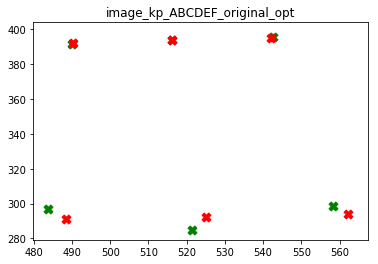

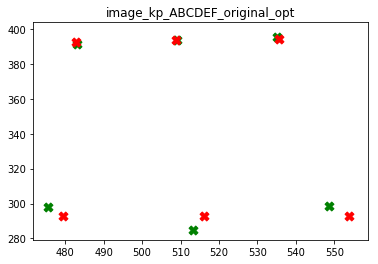

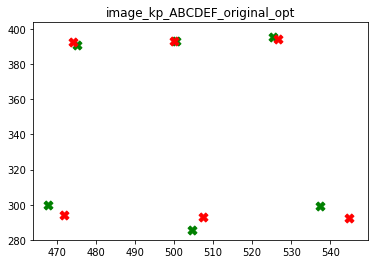

In [27]:
visual = np.zeros((11+3,1))
for i in range(frame):
    visual = mat(para_data[i]).T
    getfx_visual = getFx(visual, 1)
    visual2D(kp[i], getfx_visual)

In [28]:
def visual3D(img_gt, para):
    K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                 [0.0, 1147.59161666764, 508.064917088557],
                 [0.0, 0.0, 1.0]])
    r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33 = symbols('r11 r12 r13 r14 r21 r22 r23 r24 r31 r32 r33')
    Rt = Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, 1]])
    a, b, c = symbols('a b c')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    XA = Matrix([[-a * c], [c], [0], [1]])
    XB = Matrix([[0], [c], [0], [1]])
    XC = Matrix([[a * c], [c], [0], [1]])
    XD = Matrix([[-b * c], [0], [0], [1]])
    XE = Matrix([[0], [0], [0], [1]])
    XF = Matrix([[b * c], [0], [0], [1]])
    A3D = Rt * XA
    B3D = Rt * XB
    C3D = Rt * XC
    D3D = Rt * XD
    E3D = Rt * XE
    F3D = Rt * XF
    j = 0
    #A3D_value = A3D.subs({r11:para[13*j], r12:para[13*j+1], r13:para[13*j+2], r14:para[13*j+3], 
    #            r21:para[13*j+4], r22:para[13*j+5], r23:para[13*j+6], r24:para[13*j+7], 
    #            r31:para[13*j+8], r32:para[13*j+9], r33:para[13*j+10], th:para[13*j+11], 
    #            al:para[13*j+12], a:para[-3], b:para[-2], c:para[-1]})
    Y = mat([img_gt[0][0], img_gt[1][0], img_gt[2][0]]).T
    s = Y[2,0]
    print(s)
    #A3D_value = getValue(A3D, para) * s
    A3D_value = A3D.subs({r11:para[0], r12:para[1], r13:para[2], r14:para[3], 
        r21:para[4], r22:para[5], r23:para[6], r24:para[7], 
        r31:para[8], r32:para[9], r33:para[10], a:para[-3], b:para[-2], c:para[-1]}) * s
    B3D_value = B3D.subs({r11:para[0], r12:para[1], r13:para[2], r14:para[3], 
        r21:para[4], r22:para[5], r23:para[6], r24:para[7], 
        r31:para[8], r32:para[9], r33:para[10], a:para[-3], b:para[-2], c:para[-1]}) * s
    C3D_value = C3D.subs({r11:para[0], r12:para[1], r13:para[2], r14:para[3], 
        r21:para[4], r22:para[5], r23:para[6], r24:para[7], 
        r31:para[8], r32:para[9], r33:para[10], a:para[-3], b:para[-2], c:para[-1]}) * s
    D3D_value = D3D.subs({r11:para[0], r12:para[1], r13:para[2], r14:para[3], 
        r21:para[4], r22:para[5], r23:para[6], r24:para[7], 
        r31:para[8], r32:para[9], r33:para[10], a:para[-3], b:para[-2], c:para[-1]}) * s
    E3D_value = E3D.subs({r11:para[0], r12:para[1], r13:para[2], r14:para[3], 
        r21:para[4], r22:para[5], r23:para[6], r24:para[7], 
        r31:para[8], r32:para[9], r33:para[10], a:para[-3], b:para[-2], c:para[-1]}) * s
    F3D_value = F3D.subs({r11:para[0], r12:para[1], r13:para[2], r14:para[3], 
        r21:para[4], r22:para[5], r23:para[6], r24:para[7], 
        r31:para[8], r32:para[9], r33:para[10], a:para[-3], b:para[-2], c:para[-1]}) * s
    print(A3D_value,B3D_value,C3D_value,D3D_value,E3D_value,F3D_value)
    
    X1 = mat([img_gt[0][14], img_gt[1][14], img_gt[2][14]]).T
    X2 = mat([img_gt[0][8], img_gt[1][8], img_gt[2][8]]).T
    X3 = mat([img_gt[0][11], img_gt[1][11], img_gt[2][11]]).T
    X4 = mat([img_gt[0][4], img_gt[1][4], img_gt[2][4]]).T
    X5 = mat([img_gt[0][0], img_gt[1][0], img_gt[2][0]]).T
    X6 = mat([img_gt[0][1], img_gt[1][1], img_gt[2][1]]).T
    print(X1, X2, X3, X4, X5, X6)
    
    # 绘制散点图
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X1[0], X1[1], X1[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X2[0], X2[1], X2[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X3[0], X3[1], X3[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X4[0], X4[1], X4[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X5[0], X5[1], X5[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(X6[0], X6[1], X6[2], s = 80, c = 'g', marker = 'X')
    ax.scatter(A3D_value[0], A3D_value[1], A3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(B3D_value[0], B3D_value[1], B3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(C3D_value[0], C3D_value[1], C3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(D3D_value[0], D3D_value[1], D3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(E3D_value[0], E3D_value[1], E3D_value[2], s = 80, c = 'r', marker = 'X')
    ax.scatter(F3D_value[0], F3D_value[1], F3D_value[2], s = 80, c = 'r', marker = 'X')

    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
    plt.show()
    
    # 计算3D error
    d1 = A3D_value-X1
    e1 = sum(map(lambda x:x**2, d1))
    d2 = B3D_value-X2
    e2 = sum(map(lambda x:x**2, d2))
    d3 = C3D_value-X3
    e3 = sum(map(lambda x:x**2, d3))
    d4 = D3D_value-X4
    e4 = sum(map(lambda x:x**2, d4))
    d5 = E3D_value-X5
    e5 = sum(map(lambda x:x**2, d5))
    d6 = F3D_value-X6
    e6 = sum(map(lambda x:x**2, d6))
    error = (e1**(0.5)+e2**(0.5)+e3**(0.5)+e4**(0.5)+e5**(0.5)+e6**(0.5))/6
    print(error)
    print(d1,d2,d3,d4,d5,d6)

5431.021804471869
Matrix([[-96.6199566665384], [-1035.88708966717], [5477.86822930922]]) Matrix([[76.7788822254513], [-1020.16695743550], [5428.58236872244]]) Matrix([[250.177721117441], [-1004.44682520382], [5379.29650813567]]) Matrix([[-88.2340973673426], [-552.590396701494], [5465.78679922394]]) Matrix([[34.0770412092419], [-541.501814539601], [5431.02180447187]]) Matrix([[156.388179785826], [-530.413232377707], [5396.25680971980]])
[[-116.13794622]
 [-981.55022671]
 [5337.56816021]] [[   58.10612376]
 [-1032.54818762]
 [ 5312.38145874]] [[ 229.57596842]
 [-974.23751811]
 [5340.55881868]] [[ -88.47243168]
 [-551.69897883]
 [5430.16427386]] [[  35.17832488]
 [-541.48752095]
 [5431.02180447]] [[ 158.81323565]
 [-531.08752521]
 [5431.94416176]]


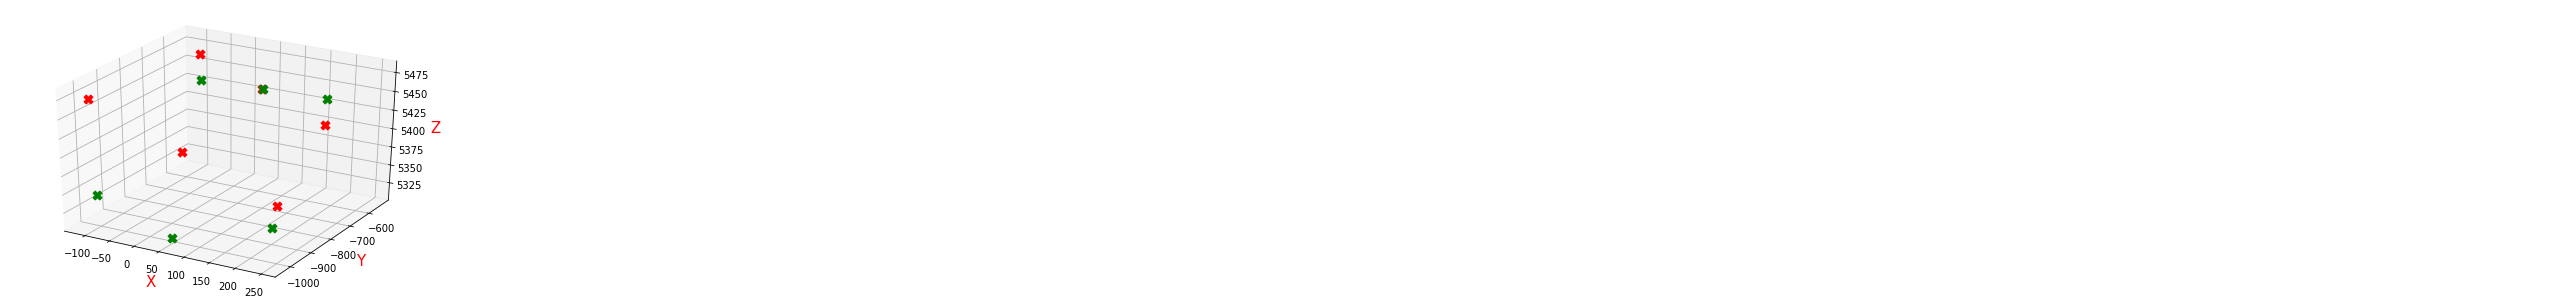

65.9729795255331
Matrix([[19.5179895549403], [-54.3368629554715], [140.300069097630]]) Matrix([[18.6727584651096], [12.3812301891362], [116.200909979356]]) Matrix([[20.6017526942385], [-30.2093070900012], [38.7376894583131]]) Matrix([[0.238334308739724], [-0.891417872685452], [35.6225253655493]]) Matrix([[-1.10128367001688], [-0.0142935880392088], [0]]) Matrix([[-2.42505586149051], [0.674292834931634], [-35.6873520389208]])
5433.287829883042
Matrix([[-140.066643276771], [-1030.90054871427], [5499.58448559123]]) Matrix([[34.3997631404416], [-1017.69650852469], [5428.59903239768]]) Matrix([[208.866169557655], [-1004.49246833511], [5357.61357920414]]) Matrix([[-124.737321399445], [-551.628436376570], [5484.16932691055]]) Matrix([[0.318046146247553], [-542.163943280705], [5433.28782988304]]) Matrix([[125.373413691940], [-532.699450184839], [5382.40633285554]])
[[-153.68046148]
 [-974.22112528]
 [5319.75324258]] [[   19.80977102]
 [-1033.23488078]
 [ 5315.92260793]] [[ 185.50850613]
 [-979.

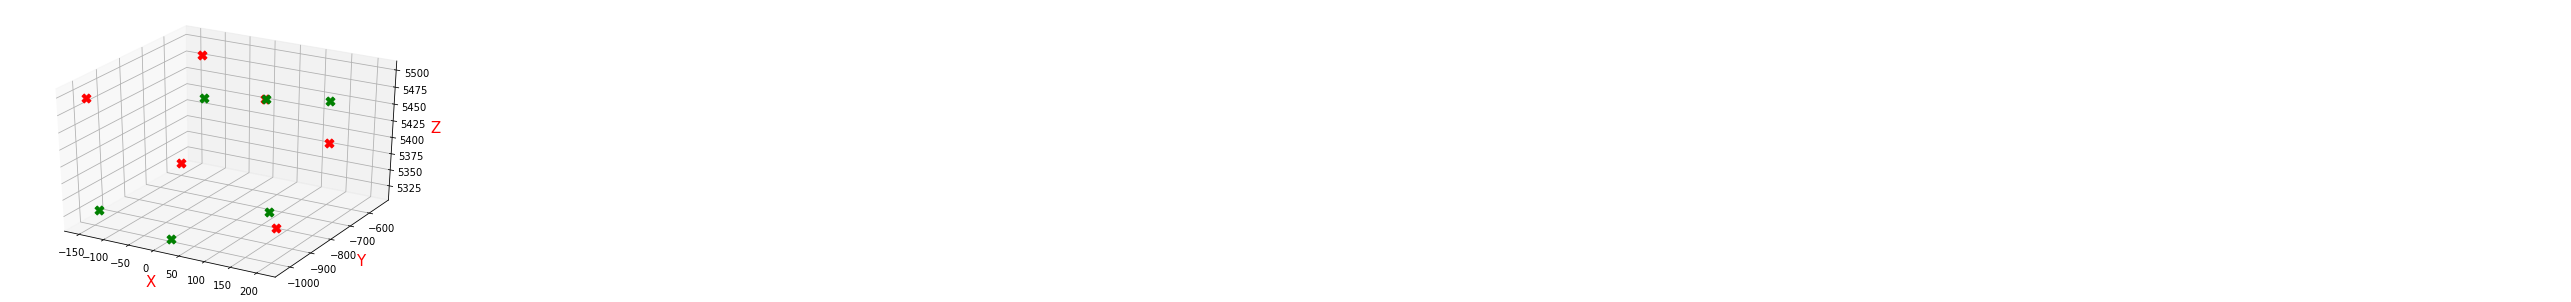

78.4036354532850
Matrix([[13.6138182017122], [-56.6794234326426], [179.831243013039]]) Matrix([[14.5899921208515], [15.5383722542202], [112.676424472055]]) Matrix([[23.3576634258197], [-24.7902353745862], [-15.5295689157692]]) Matrix([[-3.14145082333363], [-1.37563373717376], [63.9470930123298]]) Matrix([[-1.20501793314507], [-0.00663063851970946], [0]]) Matrix([[0.750435168211339], [1.17387292759145], [-64.0111731936522]])
5450.435931254344
Matrix([[-179.285557986117], [-1034.09941807355], [5543.38108921287]]) Matrix([[-6.40239029532299], [-1018.68729138142], [5439.43809304418]]) Matrix([[166.480777395471], [-1003.27516468928], [5335.49509687549]]) Matrix([[-167.267794134315], [-556.454687694086], [5525.75541536178]]) Matrix([[-41.9926771827373], [-545.286706452076], [5450.43593125434]]) Matrix([[83.2824397688403], [-534.118725210066], [5375.11644714691]])
[[-189.06316845]
 [-959.07244598]
 [5291.33076613]] [[  -19.20508812]
 [-1026.82118409]
 [ 5303.76052482]] [[ 133.64030616]
 [-982

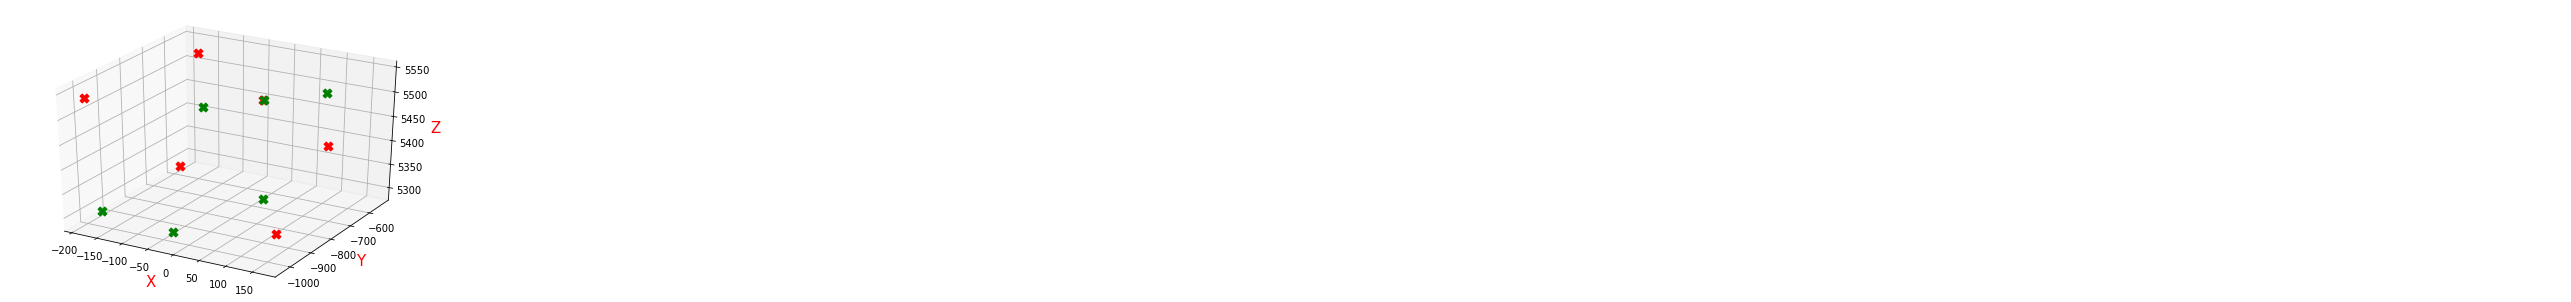

115.893354707446
Matrix([[9.77761046445661], [-75.0269720941193], [252.050323082196]]) Matrix([[12.8026978199550], [8.13389270987727], [135.677568226024]]) Matrix([[32.8404712371679], [-20.8725650995283], [-59.1570129250113]]) Matrix([[-8.67623897191044], [-3.86594398778095], [111.142057554895]]) Matrix([[-1.96395701984194], [-0.0543352159941151], [0]]) Matrix([[4.77643252947372], [3.56691669559029], [-111.196595070344]])


In [29]:
visual3d = np.zeros((11+3,1))
for i in range(frame):
    visual3d = mat(para_data[i]).T
    visual3D(img_gt[i], visual3d)